# Import Libraries and Data

In [ ]:
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pyarrow    # parquet engine library

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

sns.set_palette("Paired") # crest

%pylab inline
%matplotlib inline

pd.set_option('expand_frame_repr', False)  
pd.set_option('display.max_rows', None)   

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_path = '/content/drive/MyDrive/Amex_Default_Prediction_Kaggle_Competition/train.parquet'
train = pd.read_parquet(train_path)



In [ ]:
label_path = '/content/drive/MyDrive/Amex_Default_Prediction_Kaggle_Competition/train_labels.csv'
label = pd.read_csv(label_path)


# Data Overview

In [ ]:
train.shape

(5531451, 190)

In [ ]:
train.head(5)

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0,0.008724,1.006838,0.009228,0.124035,0.0,0.004709,...,-1,-1,-1,0,0,0.0,NaN,0,0.000610,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0,0.004923,1.000653,0.006151,0.126750,0.0,0.002714,...,-1,-1,-1,0,0,0.0,NaN,0,0.005492,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954180,3,0.021655,1.009672,0.006815,0.123977,0.0,0.009423,...,-1,-1,-1,0,0,0.0,NaN,0,0.006986,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960384,0,0.013683,1.002700,0.001373,0.117169,0.0,0.005531,...,-1,-1,-1,0,0,0.0,NaN,0,0.006527,0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947248,0,0.015193,1.000727,0.007605,0.117325,0.0,0.009312,...,-1,-1,-1,0,0,0.0,NaN,0,0.008126,0


In [ ]:
train.dtypes

customer_ID     object
S_2             object
P_2            float32
D_39             int16
B_1            float32
B_2            float32
R_1            float32
S_3            float32
D_41           float32
B_3            float32
D_42           float32
D_43           float32
D_44              int8
B_4              int16
D_45           float32
B_5            float32
R_2               int8
D_46           float32
D_47           float32
D_48           float32
D_49             int16
B_6            float32
B_7            float32
B_8            float32
D_50           float32
D_51              int8
B_9            float32
R_3               int8
D_52           float32
P_3            float32
B_10           float32
D_53           float32
S_5            float32
B_11           float32
S_6               int8
D_54           float32
R_4               int8
S_7            float32
B_12           float32
S_8              int16
D_55           float32
D_56           float32
B_13           float32
R_5        

In [ ]:
label.shape

(458913, 2)

In [ ]:
label.head(5)

,customer_ID,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,0
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,0


In [ ]:
label.target.value_counts(normalize = True)

0    0.741066
1    0.258934
Name: target, dtype: float64

In [ ]:
cat_features =  ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120',  'D_126', 'D_63', 'D_64', 'D_66', 'D_68'] 
len(cat_features)

11

In [ ]:
features = train.drop(['customer_ID', 'S_2' ], axis = 1).columns.to_list()
len(features)

188

In [ ]:
num_features = [col for col in features if col not in cat_features]
len(num_features)

177

# Customer Profile

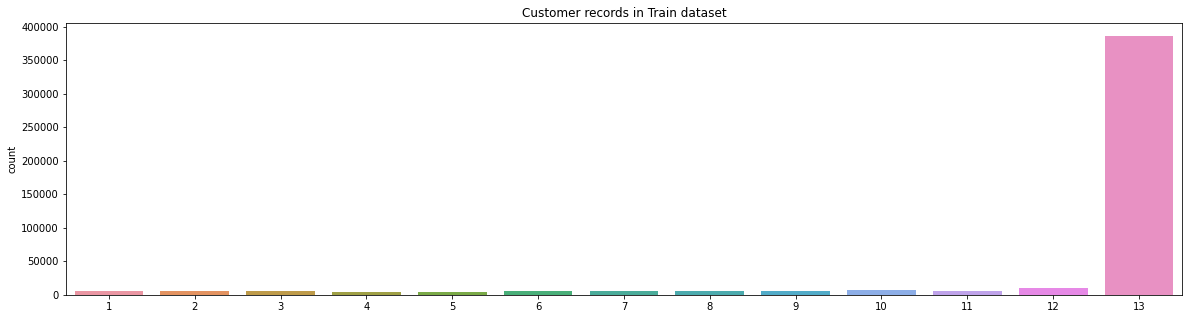

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))
sns.countplot(x=train.groupby('customer_ID')['customer_ID'].count().values)
plt.title('Customer records in Train dataset')
plt.show()

In [ ]:
train['S_2'] = pd.to_datetime(train['S_2'])

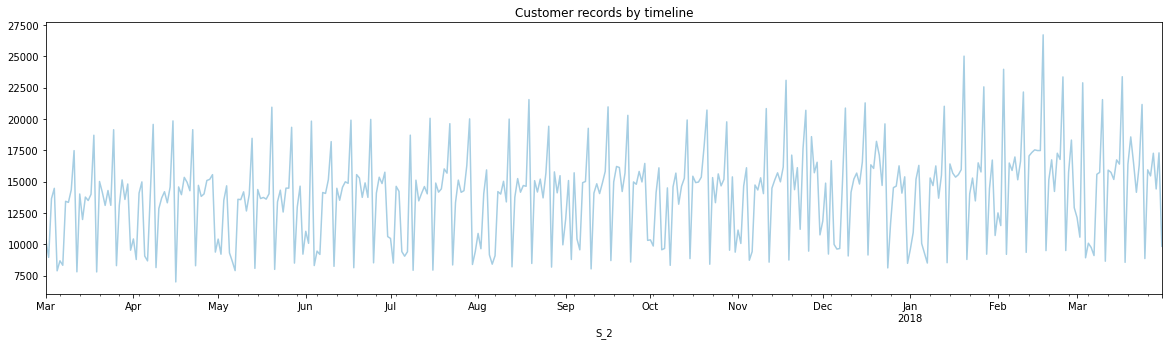

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))
train.groupby("S_2")['customer_ID'].count().plot()
plt.title("Customer records by timeline")
plt.show()

# Data Information

D_* = Delinquency variables
S_* = Spend variables
P_* = Payment variables
B_* = Balance variables
R_* = Risk variables

In [ ]:
len(train.columns)

190

In [ ]:
feature_count = {}
for col in train.columns:
  if col.startswith('S_'):
    feature_count['Spend Variables'] = feature_count.get('Spend Variables', 0) +1
  if col.startswith('D_'):
    feature_count['Delinquency Variables'] = feature_count.get('Delinquency Variables', 0) +1
  if col.startswith('B_'):
    feature_count['Balance Variables'] = feature_count.get('Balance Variables', 0) +1
  if col.startswith('R_'):
   feature_count['Risk Variables'] = feature_count.get('Risk Variables', 0) +1   
  if col.startswith('P_'):
   feature_count['Payment Variables'] = feature_count.get('Payment Variables', 0) +1  


In [ ]:
feature_count

{'Spend Variables': 22,
 'Payment Variables': 3,
 'Delinquency Variables': 96,
 'Balance Variables': 40,
 'Risk Variables': 28}

In [ ]:
# Spend variables include S-2 time features

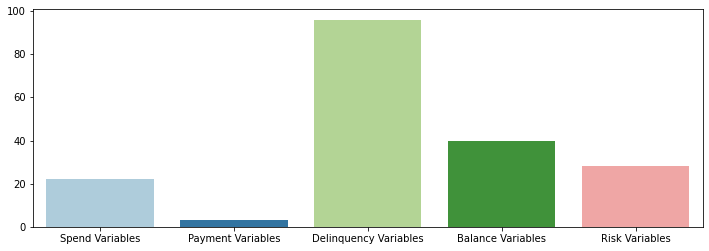

In [ ]:
plt.figure(figsize = (12,4))
sns.barplot(x = list(feature_count.keys()), y = list(feature_count.values()));

# D columns - Delinquency variables
Delinquency variables : Bad or Criminal behaviour

In [ ]:
a_list = ['B_30']
a_columns = [col for col in train.columns if col in a_list]
a_columns

['B_30']

In [ ]:
D_columns = [col  for col in train.columns if (col.startswith('D_') and col not in cat_features)]
D_columns

['D_39',
 'D_41',
 'D_42',
 'D_43',
 'D_44',
 'D_45',
 'D_46',
 'D_47',
 'D_48',
 'D_49',
 'D_50',
 'D_51',
 'D_52',
 'D_53',
 'D_54',
 'D_55',
 'D_56',
 'D_58',
 'D_59',
 'D_60',
 'D_61',
 'D_62',
 'D_65',
 'D_69',
 'D_70',
 'D_71',
 'D_72',
 'D_73',
 'D_74',
 'D_75',
 'D_76',
 'D_77',
 'D_78',
 'D_79',
 'D_80',
 'D_81',
 'D_82',
 'D_83',
 'D_84',
 'D_86',
 'D_87',
 'D_88',
 'D_89',
 'D_91',
 'D_92',
 'D_93',
 'D_94',
 'D_96',
 'D_102',
 'D_103',
 'D_104',
 'D_105',
 'D_106',
 'D_107',
 'D_108',
 'D_109',
 'D_110',
 'D_111',
 'D_112',
 'D_113',
 'D_115',
 'D_118',
 'D_119',
 'D_121',
 'D_122',
 'D_123',
 'D_124',
 'D_125',
 'D_127',
 'D_128',
 'D_129',
 'D_130',
 'D_131',
 'D_132',
 'D_133',
 'D_134',
 'D_135',
 'D_136',
 'D_137',
 'D_138',
 'D_139',
 'D_140',
 'D_141',
 'D_142',
 'D_143',
 'D_144',
 'D_145']

In [ ]:
len(D_columns)  

87

In [ ]:
D_columns_1 = D_columns[0:20]
D_1 = train[D_columns_1]
D_1.shape

(5531451, 20)

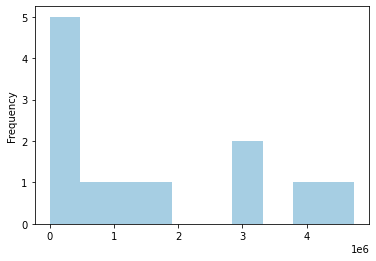

In [ ]:
D_1null = D_1.isna().sum().sort_values(ascending = False)
D_1null[D_1null > 0].plot(kind = 'hist')


In [ ]:
(D_1.isna().sum()/len(D_1)).sort_values(ascending = False)

D_42    0.856943
D_53    0.738429
D_50    0.568097
D_56    0.540716
D_43    0.299812
D_46    0.219056
D_48    0.129934
D_55    0.033409
D_52    0.005345
D_45    0.000365
D_54    0.000364
D_41    0.000364
D_59    0.000000
D_58    0.000000
D_39    0.000000
D_51    0.000000
D_49    0.000000
D_47    0.000000
D_44    0.000000
D_60    0.000000
dtype: float64

In [ ]:
null_columns_d = [col for col in D_1.columns if D_1[col].isnull().any()]
null_columns_d

['D_41',
 'D_42',
 'D_43',
 'D_45',
 'D_46',
 'D_48',
 'D_50',
 'D_52',
 'D_53',
 'D_54',
 'D_55',
 'D_56']

In [ ]:
null_80 = [col for col in D_1.columns if D_1[col].isnull().sum() > 0.80 * len(D_1)]
null_80

['D_42']

In [ ]:
round(train.isna().sum()/len(train), 4).sort_values(ascending = False)

D_88           0.9989
D_110          0.9943
B_39           0.9939
D_73           0.9899
B_42           0.9871
D_134          0.9648
B_29           0.9310
D_132          0.9019
D_76           0.8875
D_42           0.8569
D_142          0.8293
D_53           0.7384
D_50           0.5681
B_17           0.5672
D_105          0.5462
D_56           0.5407
S_9            0.5304
D_77           0.4545
D_43           0.2998
S_27           0.2533
D_46           0.2191
S_3            0.1845
S_7            0.1845
D_62           0.1371
D_48           0.1299
D_61           0.1081
P_3            0.0545
D_69           0.0352
D_55           0.0334
D_118          0.0319
D_121          0.0319
D_119          0.0319
D_115          0.0319
R_27           0.0233
D_141          0.0184
D_104          0.0184
D_130          0.0184
D_131          0.0184
D_128          0.0184
B_13           0.0090
P_2            0.0083
D_133          0.0077
D_144          0.0074
D_102          0.0073
D_52           0.0053
B_8       

In [ ]:
null_99_drop = [col for col in train.columns if train[col].isnull().sum() > 0.99 * len(train)]
null_99_drop

['D_88', 'D_110', 'B_39']

In [ ]:
null_columns = [col for col in train.columns if (train[col].isnull().any()) and ( col not in null_99_drop)]
null_columns

['P_2',
 'B_2',
 'S_3',
 'D_41',
 'B_3',
 'D_42',
 'D_43',
 'D_45',
 'D_46',
 'D_48',
 'B_6',
 'B_8',
 'D_50',
 'D_52',
 'P_3',
 'D_53',
 'D_54',
 'S_7',
 'D_55',
 'D_56',
 'B_13',
 'S_9',
 'D_61',
 'B_15',
 'D_62',
 'B_17',
 'D_69',
 'D_73',
 'D_76',
 'R_7',
 'D_77',
 'B_25',
 'B_26',
 'B_27',
 'R_12',
 'R_14',
 'B_29',
 'S_22',
 'S_23',
 'S_24',
 'S_25',
 'S_26',
 'D_102',
 'D_104',
 'D_105',
 'B_37',
 'R_27',
 'D_112',
 'B_40',
 'S_27',
 'D_115',
 'D_118',
 'D_119',
 'D_121',
 'D_128',
 'B_42',
 'D_130',
 'D_131',
 'D_132',
 'D_133',
 'D_134',
 'D_141',
 'D_142',
 'D_144']

In [ ]:
D_1null

D_42    4740137
D_53    4084585
D_50    3142402
D_56    2990943
D_43    1658396
D_46    1211699
D_48     718725
D_55     184803
D_52      29563
D_45       2017
D_54       2016
D_41       2016
D_59          0
D_58          0
D_39          0
D_51          0
D_49          0
D_47          0
D_44          0
D_60          0
dtype: int64

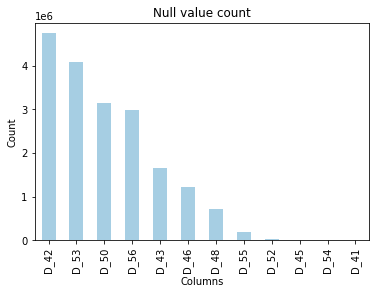

In [ ]:
  plt.title('Null value count')
  plt.xlabel('Columns')
  plt.ylabel('Count')
  D_1null = D_1.isna().sum().sort_values(ascending = False)
  D_1null[D_1null > 0].plot(kind = 'bar')
  plt.show()

In [ ]:
def show_null(data):
  plt.figure(figsize = (10,10))
  plt.title('Null value count')
  plt.xlabel('Columns')
  plt.ylabel('Count')
  plt.ticklabel_format(style = 'plain')
  data_null = data.isna().sum().sort_values()
  data_null[data_null > 0].plot(kind = 'barh')
  print(data_null[data_null >0])
  plt.show()

D_41        2016
D_54        2016
D_45        2017
D_112       2650
D_52       29563
D_102      40655
D_144      40727
D_133      42716
D_131     101548
D_130     101548
D_128     101548
D_141     101548
D_104     101548
D_115     176716
D_119     176716
D_118     176716
D_121     176716
D_55      184803
D_69      194473
D_61      598052
D_48      718725
D_62      758161
D_46     1211699
D_43     1658396
D_77     2513912
D_56     2990943
D_105    3021431
D_50     3142402
D_53     4084585
D_142    4587043
D_42     4740137
D_76     4908954
D_132    4988874
D_134    5336752
D_73     5475595
D_110    5500117
D_88     5525447
dtype: int64


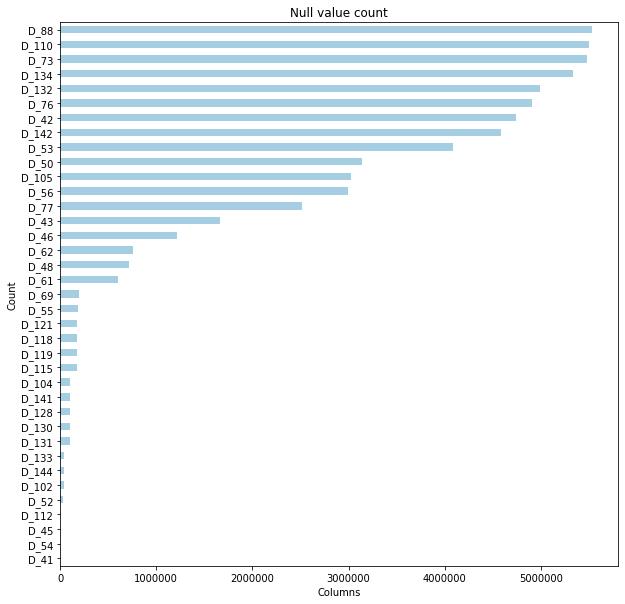

In [ ]:
show_null(train[D_columns])



```
# This is formatted as code
```

# S columns - Spend variables

In [ ]:
S_columns = [col  for col in train.columns if (col.startswith('S_') and col not in cat_features)]
S_columns

['S_2',
 'S_3',
 'S_5',
 'S_6',
 'S_7',
 'S_8',
 'S_9',
 'S_11',
 'S_12',
 'S_13',
 'S_15',
 'S_16',
 'S_17',
 'S_18',
 'S_19',
 'S_20',
 'S_22',
 'S_23',
 'S_24',
 'S_25',
 'S_26',
 'S_27']

S_23        445
S_26        634
S_25      12847
S_24      18593
S_22      19024
S_7     1020544
S_3     1020544
S_27    1400935
S_9     2933643
dtype: int64


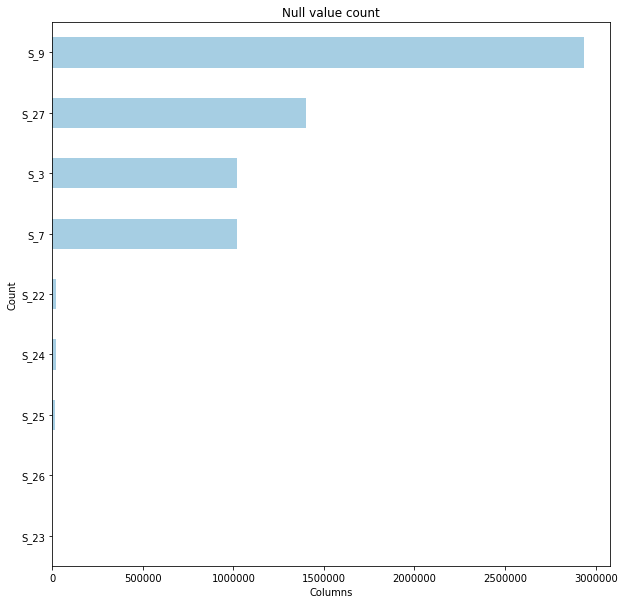

In [ ]:
show_null(train[S_columns])

# P_columns - Payment variables

In [ ]:
P_columns = [col  for col in train.columns if (col.startswith('P_') and col not in cat_features)]
P_columns

['P_2', 'P_3', 'P_4']

P_2     45985
P_3    301492
dtype: int64


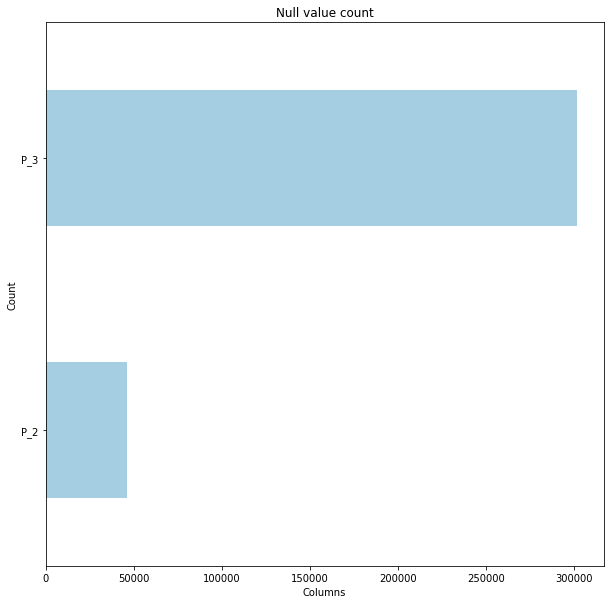

In [ ]:
show_null(train[P_columns])

In [ ]:
train[P_columns].head(4)

,P_2,P_3,P_4
0,0.938469,0.736463,0.0
1,0.936665,0.720886,0.0
2,0.954180,0.738044,0.0
3,0.960384,0.741813,0.0


In [ ]:
train['P_2'].quantile([0.5])

0.5    0.694295
Name: P_2, dtype: float32

# B_columns - Balance variables

In [ ]:
B_columns = [col  for col in train.columns if (col.startswith('B_') and col not in cat_features)]
B_columns

['B_1',
 'B_2',
 'B_3',
 'B_4',
 'B_5',
 'B_6',
 'B_7',
 'B_8',
 'B_9',
 'B_10',
 'B_11',
 'B_12',
 'B_13',
 'B_14',
 'B_15',
 'B_16',
 'B_17',
 'B_18',
 'B_19',
 'B_20',
 'B_21',
 'B_22',
 'B_23',
 'B_24',
 'B_25',
 'B_26',
 'B_27',
 'B_28',
 'B_29',
 'B_31',
 'B_32',
 'B_33',
 'B_36',
 'B_37',
 'B_39',
 'B_40',
 'B_41',
 'B_42']

B_40         53
B_37         56
B_6         233
B_2        2016
B_3        2016
B_27       2016
B_26       2016
B_15       6923
B_25       6923
B_8       22268
B_13      49519
B_17    3137598
B_29    5150035
B_42    5459973
B_39    5497819
dtype: int64


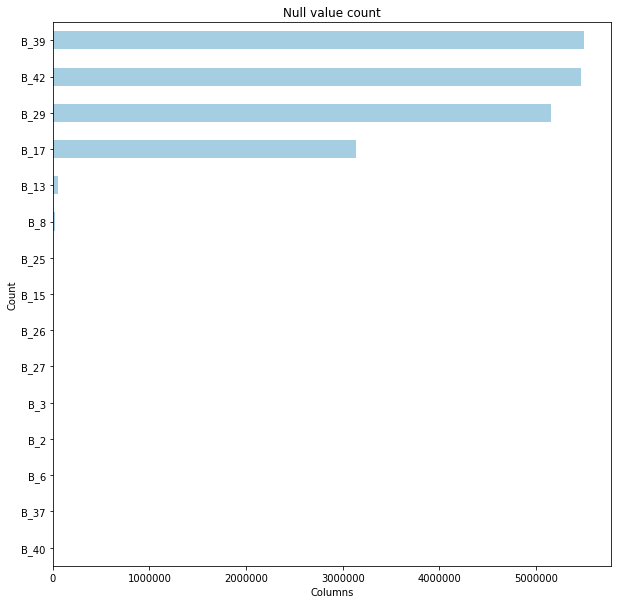

In [ ]:
show_null(train[B_columns])

# R columns  - Risk variables

In [ ]:
R_columns = [col  for col in train.columns if (col.startswith('R_') and col not in cat_features)]
R_columns

['R_1',
 'R_2',
 'R_3',
 'R_4',
 'R_5',
 'R_6',
 'R_7',
 'R_8',
 'R_9',
 'R_10',
 'R_11',
 'R_12',
 'R_13',
 'R_14',
 'R_15',
 'R_16',
 'R_17',
 'R_18',
 'R_19',
 'R_20',
 'R_21',
 'R_22',
 'R_23',
 'R_24',
 'R_25',
 'R_26',
 'R_27',
 'R_28']

R_7          1
R_14         1
R_12        56
R_27    128703
dtype: int64


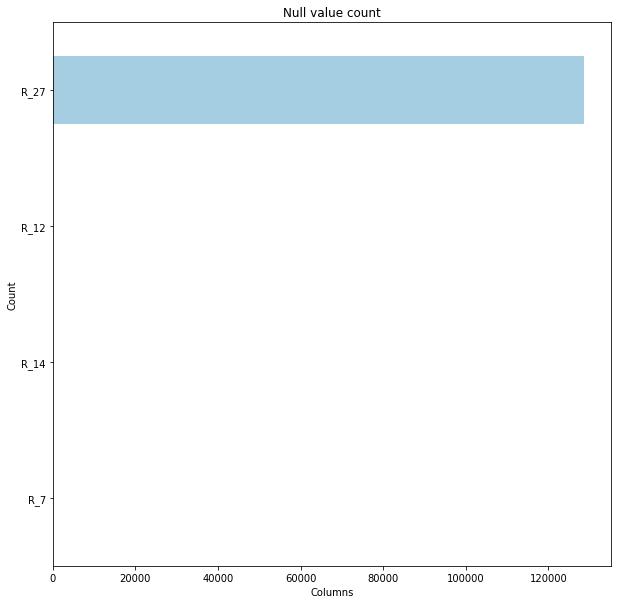

In [ ]:
show_null(train[R_columns])

# Categarical Columns

In [ ]:
cat_features

['B_30',
 'B_38',
 'D_114',
 'D_116',
 'D_117',
 'D_120',
 'D_126',
 'D_63',
 'D_64',
 'D_66',
 'D_68']

In [ ]:
len(cat_features)

11

In [ ]:
train[cat_features].dtypes

B_30     int8
B_38     int8
D_114    int8
D_116    int8
D_117    int8
D_120    int8
D_126    int8
D_63     int8
D_64     int8
D_66     int8
D_68     int8
dtype: object

In [ ]:
cat_features[0]

'B_30'

In [ ]:
train[cat_features[0]].unique()

array([ 0,  2,  1, -1], dtype=int8)

In [ ]:
train[cat_features[0]].value_counts(normalize = True)

 0    0.851614
 1    0.138111
 2    0.009910
-1    0.000364
Name: B_30, dtype: float64

In [ ]:
train[cat_features].isnull().sum()

B_30     0
B_38     0
D_114    0
D_116    0
D_117    0
D_120    0
D_126    0
D_63     0
D_64     0
D_66     0
D_68     0
dtype: int64

B_30
[ 0  2  1 -1]
 0    0.851614
 1    0.138111
 2    0.009910
-1    0.000364
Name: B_30, dtype: float64


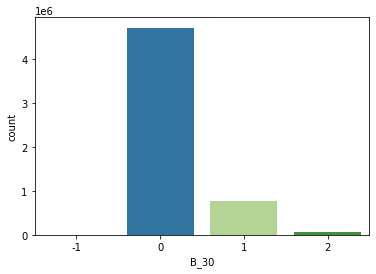

B_38
[ 2  1  3  5  6  7  4 -1]
 2    0.353114
 3    0.226941
 1    0.209718
 5    0.080423
 4    0.053316
 7    0.046828
 6    0.029294
-1    0.000364
Name: B_38, dtype: float64


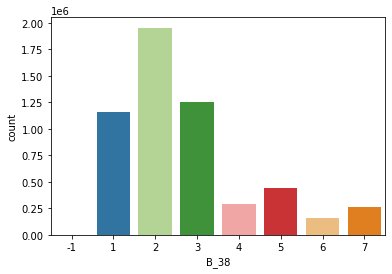

D_114
[ 1  0 -1]
 1    0.599567
 0    0.368485
-1    0.031947
Name: D_114, dtype: float64


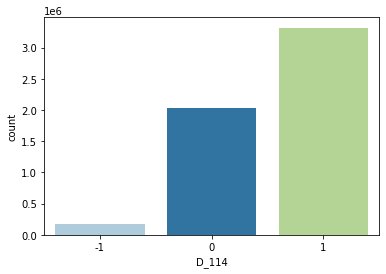

D_116
[ 0 -1  1]
 0    0.966855
-1    0.031947
 1    0.001198
Name: D_116, dtype: float64


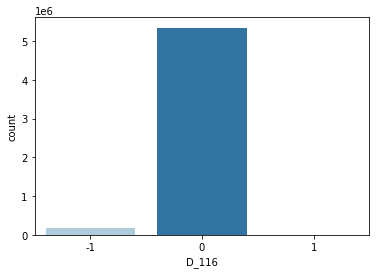

D_117
[ 5  0  7  3  2 -1  4  6]
 0    0.263237
 4    0.210867
 5    0.205853
 3    0.120548
 6    0.083032
 7    0.062284
-1    0.031947
 2    0.022231
Name: D_117, dtype: float64


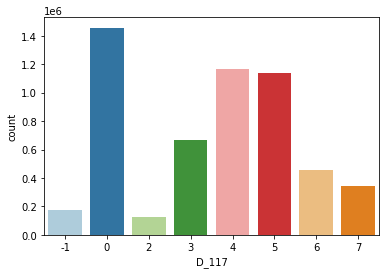

D_120
[ 0  1 -1]
 0    0.855060
 1    0.112992
-1    0.031947
Name: D_120, dtype: float64


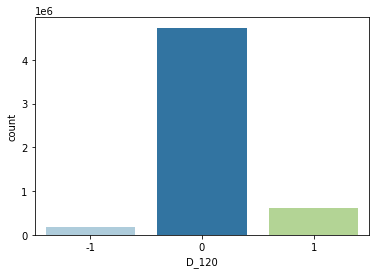

D_126
[ 2 -1  1  0]
 2    0.770578
 1    0.161137
 0    0.047166
-1    0.021119
Name: D_126, dtype: float64


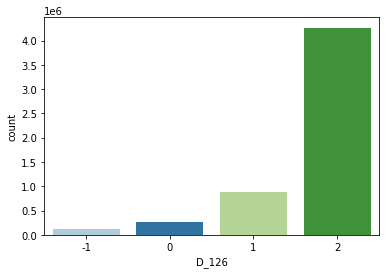

D_63
[0 3 4 1 2 5]
3    0.744763
0    0.168154
4    0.079254
1    0.004662
2    0.001908
5    0.001259
Name: D_63, dtype: float64


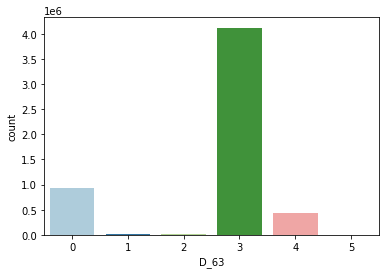

D_64
[ 0  2 -1  3  1]
 0    0.526669
 3    0.275416
 2    0.151879
-1    0.039310
 1    0.006726
Name: D_64, dtype: float64


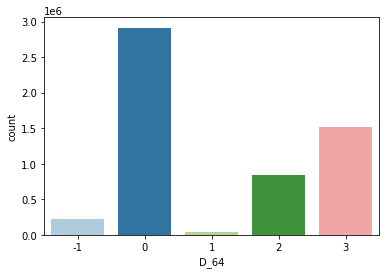

D_66
[-1  1  0]
-1    0.887307
 1    0.111556
 0    0.001137
Name: D_66, dtype: float64


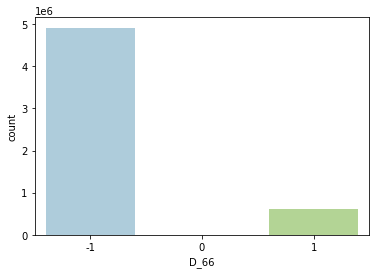

D_68
[ 6  2  3 -1  5  4  0  1]
 6    0.503024
 5    0.217250
 3    0.087580
 4    0.086268
 2    0.039793
-1    0.039140
 1    0.024066
 0    0.002879
Name: D_68, dtype: float64


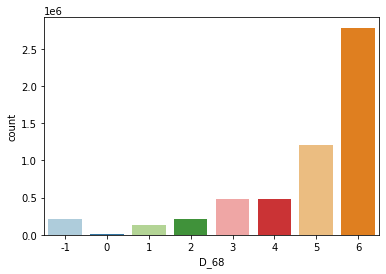

In [ ]:
for i in range(0, len(cat_features)):
  print(cat_features[i])
  print(train[cat_features[i]].unique())
  print(train[cat_features[i]].value_counts(normalize = True))
  sns.countplot( x= cat_features[i], data = train)
  plt.show()

# Missing Values processing

In [ ]:
null_count = train.isna().sum().sort_values(ascending = False)
null_count_len = null_count[null_count > 0]
len(null_count_len)

67

In [ ]:
round(train.isna().sum()/len(train), 4).sort_values(ascending = False)

In [ ]:
#null_99_drop = [col for col in train.columns if train[col].isnull().sum() > 0.99 * len(train)]
#null_99_drop

In [ ]:
null_90_drop = [col for col in train.columns if train[col].isnull().sum() > 0.90 * len(train)]
null_90_drop

['D_73', 'B_29', 'D_88', 'D_110', 'B_39', 'B_42', 'D_132', 'D_134']

In [ ]:
null_columns = [col for col in train.columns if (train[col].isnull().any()) and ( col not in null_90_drop)]
null_columns

['P_2',
 'B_2',
 'S_3',
 'D_41',
 'B_3',
 'D_42',
 'D_43',
 'D_45',
 'D_46',
 'D_48',
 'B_6',
 'B_8',
 'D_50',
 'D_52',
 'P_3',
 'D_53',
 'D_54',
 'S_7',
 'D_55',
 'D_56',
 'B_13',
 'S_9',
 'D_61',
 'B_15',
 'D_62',
 'B_17',
 'D_69',
 'D_76',
 'R_7',
 'D_77',
 'B_25',
 'B_26',
 'B_27',
 'R_12',
 'R_14',
 'S_22',
 'S_23',
 'S_24',
 'S_25',
 'S_26',
 'D_102',
 'D_104',
 'D_105',
 'B_37',
 'R_27',
 'D_112',
 'B_40',
 'S_27',
 'D_115',
 'D_118',
 'D_119',
 'D_121',
 'D_128',
 'D_130',
 'D_131',
 'D_133',
 'D_141',
 'D_142',
 'D_144']

In [ ]:
train = train.drop(null_90_drop, axis = 1)


In [ ]:
train.head(1)

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0,0.008724,1.006838,0.009228,0.124035,0.0,0.004709,...,-1,-1,-1,0,0,0.0,NaN,0,0.00061,0


In [ ]:
train.S_2 = pd.to_datetime(train.S_2)

In [ ]:
train.dtypes

customer_ID            object
S_2            datetime64[ns]
P_2                   float32
D_39                    int16
B_1                   float32
B_2                   float32
R_1                   float32
S_3                   float32
D_41                  float32
B_3                   float32
D_42                  float32
D_43                  float32
D_44                     int8
B_4                     int16
D_45                  float32
B_5                   float32
R_2                      int8
D_46                  float32
D_47                  float32
D_48                  float32
D_49                    int16
B_6                   float32
B_7                   float32
B_8                   float32
D_50                  float32
D_51                     int8
B_9                   float32
R_3                      int8
D_52                  float32
P_3                   float32
B_10                  float32
D_53                  float32
S_5                   float32
B_11      

In [ ]:
train = train.sort_values(['customer_ID', 'S_2', ], ascending=[True, True])
train.head(20)

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0,0.008724,1.006838,0.009228,0.124035,0.0,0.004709,...,-1,-1,-1,0,0,0.0,NaN,0,0.000610,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0,0.004923,1.000653,0.006151,0.126750,0.0,0.002714,...,-1,-1,-1,0,0,0.0,NaN,0,0.005492,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954180,3,0.021655,1.009672,0.006815,0.123977,0.0,0.009423,...,-1,-1,-1,0,0,0.0,NaN,0,0.006986,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960384,0,0.013683,1.002700,0.001373,0.117169,0.0,0.005531,...,-1,-1,-1,0,0,0.0,NaN,0,0.006527,0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947248,0,0.015193,1.000727,0.007605,0.117325,0.0,0.009312,...,-1,-1,-1,0,0,0.0,NaN,0,0.008126,0
5,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-08-04,0.945964,0,0.007863,1.005006,0.004220,0.110946,0.0,0.009866,...,-1,-1,-1,0,0,0.0,NaN,0,0.002223,0
6,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-09-18,0.940705,0,0.018859,1.008024,0.004509,0.103329,0.0,0.000783,...,-1,-1,-1,0,0,0.0,NaN,0,0.007661,0
7,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-10-08,0.914767,0,0.014324,1.000242,0.000263,0.108115,0.0,0.007836,...,-1,-1,-1,0,0,0.0,NaN,0,0.009616,0
8,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-11-20,0.950845,0,0.016888,1.003995,0.001789,0.102792,0.0,0.009817,...,-1,-1,-1,0,0,0.0,NaN,0,0.004369,0
9,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-12-04,0.868580,0,0.001930,1.007504,0.001772,0.100470,0.0,0.006073,...,-1,-1,-1,0,0,0.0,NaN,0,0.004753,0


In [ ]:
train=train.set_index(['customer_ID'])
train=train.fillna(method='ffill').fillna(method='bfill')   # forward fill then backward fill
train=train.reset_index()
train.head(20)

#https://stackoverflow.com/questions/41589365/filling-missing-values-using-forward-and-backward-fill-in-pandas-dataframe-ffil

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0,0.008724,1.006838,0.009228,0.124035,0.0,0.004709,...,-1,-1,-1,0,0,0.0,0.141214,0,0.000610,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0,0.004923,1.000653,0.006151,0.126750,0.0,0.002714,...,-1,-1,-1,0,0,0.0,0.141214,0,0.005492,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954180,3,0.021655,1.009672,0.006815,0.123977,0.0,0.009423,...,-1,-1,-1,0,0,0.0,0.141214,0,0.006986,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960384,0,0.013683,1.002700,0.001373,0.117169,0.0,0.005531,...,-1,-1,-1,0,0,0.0,0.141214,0,0.006527,0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947248,0,0.015193,1.000727,0.007605,0.117325,0.0,0.009312,...,-1,-1,-1,0,0,0.0,0.141214,0,0.008126,0
5,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-08-04,0.945964,0,0.007863,1.005006,0.004220,0.110946,0.0,0.009866,...,-1,-1,-1,0,0,0.0,0.141214,0,0.002223,0
6,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-09-18,0.940705,0,0.018859,1.008024,0.004509,0.103329,0.0,0.000783,...,-1,-1,-1,0,0,0.0,0.141214,0,0.007661,0
7,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-10-08,0.914767,0,0.014324,1.000242,0.000263,0.108115,0.0,0.007836,...,-1,-1,-1,0,0,0.0,0.141214,0,0.009616,0
8,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-11-20,0.950845,0,0.016888,1.003995,0.001789,0.102792,0.0,0.009817,...,-1,-1,-1,0,0,0.0,0.141214,0,0.004369,0
9,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-12-04,0.868580,0,0.001930,1.007504,0.001772,0.100470,0.0,0.006073,...,-1,-1,-1,0,0,0.0,0.141214,0,0.004753,0


In [ ]:
train=train.groupby('customer_ID').tail(1)   # return last 1 row/lastest transaction of each group 
train.head(30)


In [ ]:
train=train.set_index(['customer_ID'])

In [ ]:
train.drop(['S_2'], axis =1 , inplace = True)

In [ ]:
train.isnull().sum()   #check

In [ ]:
train.head(5)

In [ ]:
train.shape

# Preprocess Function

In [ ]:
label_path = '/content/drive/MyDrive/Amex_Default_Prediction_Kaggle_Competition/train_labels.csv'
label = pd.read_csv(label_path)

In [ ]:
def preprocess_data(data):
  null_90_drop = [col for col in train.columns if train[col].isnull().sum() > 0.90 * len(train)]
  null_columns = [col for col in train.columns if (train[col].isnull().any()) and ( col not in null_90_drop)]   # these two line code doesn't need to be include in the function
  data = data.drop(null_90_drop, axis = 1)   #  drop  the columns have 90% missing value 
  data.S_2 = pd.to_datetime(data.S_2)
  data = data.sort_values(['customer_ID', 'S_2', ], ascending=[True, True]) 
  data = data.set_index(['customer_ID'])
  data = data.fillna(method='ffill').fillna(method='bfill')   # forward fill then backward fill
  data = data.reset_index()
  data = data.groupby('customer_ID').tail(1)   # get one row of each customer ID
  data.drop(['S_2'], axis =1 , inplace = True)
  
  data = data.merge(label, how='inner', on = 'customer_ID')
  return data

  condition1 = data.dtypes == 'float32'
  condition2 = data.dtypes == 'float64'
  num_cols = list(data.dtypes[(condition1)|(condition2)].index)
  for col in num_cols:
    data[col] = data[col].round(4)

In [ ]:
def check_data_info(data):
  print('first 3 rows', data.head(3))
  print('check null', data.isnull().sum())
  print('shape', data.shape)


In [ ]:
train_path = '/content/drive/MyDrive/Amex_Default_Prediction_Kaggle_Competition/train.parquet'
train_0 = pd.read_parquet(train_path)


In [ ]:
train_1 = preprocess_data(data = train_0)


In [ ]:
train_1.isnull().sum()

customer_ID    0
P_2            0
D_39           0
B_1            0
B_2            0
R_1            0
S_3            0
D_41           0
B_3            0
D_42           0
D_43           0
D_44           0
B_4            0
D_45           0
B_5            0
R_2            0
D_46           0
D_47           0
D_48           0
D_49           0
B_6            0
B_7            0
B_8            0
D_50           0
D_51           0
B_9            0
R_3            0
D_52           0
P_3            0
B_10           0
D_53           0
S_5            0
B_11           0
S_6            0
D_54           0
R_4            0
S_7            0
B_12           0
S_8            0
D_55           0
D_56           0
B_13           0
R_5            0
D_58           0
S_9            0
B_14           0
D_59           0
D_60           0
D_61           0
B_15           0
S_11           0
D_62           0
D_63           0
D_64           0
D_65           0
B_16           0
B_17           0
B_18           0
B_19          

In [ ]:
train_1.head(3)

,customer_ID,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.934745,0,0.009382,1.007647,0.006104,0.135021,0.0,0.007174,0.152932,...,-1,-1,0,0,0.0,0.141214,0,0.002970,0,0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0.880519,6,0.034684,1.004028,0.006911,0.165509,0.0,0.005068,0.152932,...,-1,-1,0,0,0.0,0.141214,0,0.003169,0,0
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0.880875,0,0.004284,0.812649,0.006450,0.165509,0.0,0.007196,0.152932,...,-1,-1,0,0,0.0,0.141214,0,0.000834,0,0


In [ ]:
train_1.shape

(458913, 190)

In [ ]:
test_path = '/content/drive/MyDrive/Amex_Default_Prediction_Kaggle_Competition/test.parquet'
test_0= pd.read_parquet(test_path)
test_0.shape

(11363762, 190)

In [ ]:
test_0.head(2)

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-02-19,0.631315,0,0.010728,0.814497,0.0,0.168651,0.0,0.002347,...,-1,-1,-1,-1,0,NaN,NaN,-1,0.008281,-1
1,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-03-25,0.587042,0,0.011026,0.810848,0.0,0.241389,0.0,0.009132,...,-1,-1,-1,0,0,0.0,NaN,0,0.003753,0


In [ ]:
def preprocess_test(data):
  null_90_drop = [col for col in train.columns if train[col].isnull().sum() > 0.90 * len(train)]
  null_columns = [col for col in train.columns if (train[col].isnull().any()) and ( col not in null_90_drop)]   # these two line code doesn't need to be include in the function
  data = data.drop(null_90_drop, axis = 1)   #  drop  the columns have 90% missing value 
  data.S_2 = pd.to_datetime(data.S_2)
  data = data.sort_values(['customer_ID', 'S_2', ], ascending=[True, True]) 
  data = data.set_index(['customer_ID'])
  data = data.fillna(method='ffill').fillna(method='bfill')   # forward fill then backward fill
  data = data.reset_index()
  data = data.groupby('customer_ID').tail(1)   # get one row of each customer ID
  data.drop(['S_2'], axis =1 , inplace = True)

  return data

In [ ]:
test_3 = preprocess_test(test_0)

In [ ]:
test_3.shape

(924621, 189)

In [ ]:
test_3.isnull().sum()

NameError: ignored

# Save Data 

In [ ]:
#save file, simple fill way
path = '/content/drive/MyDrive/Amex_Default_Prediction_Kaggle_Competition'
train_1.to_parquet(path + '/processed_sp_train.parquet', engine = 'pyarrow')   
test_3.to_parquet(path + '/processed_sp_test.parquet', engine = 'pyarrow')